## Imports

In [1]:
import urllib.request, json
import pandas as pd
import geopandas
import folium
import matplotlib.pyplot as plt
import pickle
import math
import datetime

## Queries

Download all UK site information

In [69]:
url_text = "https://webtris.highwaysengland.co.uk/api/v1/sites"
with urllib.request.urlopen(url_text) as url:
    data = json.loads(url.read().decode())

Data has two values: it's row count and a list of sites

In [70]:
data['row_count']

19147

In [71]:
sites = data['sites']
sites[0]

{'Id': '1',
 'Name': 'MIDAS site at M4/2295A2 priority 1 on link 105009001; GPS Ref: 502816;178156; Westbound',
 'Description': 'M4/2295A2',
 'Longitude': -0.520379557723297,
 'Latitude': 51.4930115367112,
 'Status': 'Inactive'}


Lets filter the sites by latitude and longitidue to a particular region of Birmingham with lots of main roads.

In [5]:
# Specify the area we are looking at
max_lat = 52.50
max_long = -1.67
min_lat = 52.42
min_long = -1.75

In [6]:
# Area ids is the set of ids for the area we are looking at
area_ids = []
area_sites = []
for site in sites:
    lat, long = site['Latitude'], site['Longitude']  # floats
    if min_lat < lat < max_lat and min_long < long < max_long:
        area_ids.append(site['Id'])
        area_sites.append(site)

In [8]:
# Quality responce is the output of our quality query for this area
quality_responces = []
for site_id in area_ids:
    url_text = f"https://webtris.highwaysengland.co.uk/api/v1/quality/overall?sites={site_id}&start_date=15062021&end_date=15062022"
    with urllib.request.urlopen(url_text) as url:
        responce = json.loads(url.read().decode())
    quality_responces.append(responce)

In [22]:
# We only want sites with quality greater than 40
good_quality_ids = []
for responce in quality_responces:
    if responce['data_quality'] >= 40:
        good_quality_ids.append(responce['sites'])
        print(responce)

{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 89, 'sites': '175'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 89, 'sites': '561'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 84, 'sites': '1102'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 70, 'sites': '1608'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 68, 'sites': '1747'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 89, 'sites': '1926'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 49, 'sites': '2017'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 73, 'sites': '2253'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022', 'data_quality': 70, 'sites': '2330'}
{'row_count': 1, 'start_date': '15062021', 'end_date': '15062022',

In [23]:
for site in area_sites:
    if site['Id'] in good_quality_ids:
        # print(site['Description'])
        print(site)

{'Id': '175', 'Name': 'MIDAS site at M42/6482L priority 1 on link 126109801; GPS Ref: 419326;288851; Southbound', 'Description': 'M42/6482L', 'Longitude': -1.71675229082771, 'Latitude': 52.4972416063519, 'Status': 'Active'}
{'Id': '561', 'Name': 'MIDAS site at M42/6473B priority 1 on link 199014703; GPS Ref: 419579;288140; Southbound', 'Description': 'M42/6473B', 'Longitude': -1.71306725093161, 'Latitude': 52.490840819676, 'Status': 'Active'}
{'Id': '1102', 'Name': 'MIDAS site at M42/6468A priority 1 on link 126109701; GPS Ref: 419673;287423; Northbound', 'Description': 'M42/6468A', 'Longitude': -1.71172500662708, 'Latitude': 52.4843916655221, 'Status': 'Active'}
{'Id': '1608', 'Name': 'MIDAS site at M6/5711L priority 1 on link 111022501; GPS Ref: 419412;286911; Southbound', 'Description': 'M6/5711L', 'Longitude': -1.71559808136676, 'Latitude': 52.4797980285909, 'Status': 'Active'}
{'Id': '1747', 'Name': 'MIDAS site at M6/5732B priority 1 on link 199014101; GPS Ref: 418100;288528; Sout

### Save Query results to pickle

In [20]:
with open('sites.pickle', 'wb') as f:
    pickle.dump(sites, f)
    
with open('quality_responces.pickle', 'wb') as f:
    pickle.dump(quality_responces, f)

## Data Processing

### Import Query results

In [2]:
with open('sites.pickle', 'rb') as f:
    sites = pickle.load(f)
    
with open('quality_responces.pickle', 'rb') as f:
    quality_responces = pickle.load(f)

### Put into dataframe

In [3]:
# Specify the area we are looking at
max_lat = 52.50
max_long = -1.67
min_lat = 52.42
min_long = -1.75

sites_df = pd.DataFrame(data = sites)
area_sites_df = sites_df.loc[(min_long < sites_df.Longitude) & (sites_df.Longitude < max_long)
                            & (min_lat < sites_df.Latitude) & (sites_df.Latitude < max_lat)]


quality_responces_df  = pd.DataFrame(data = quality_responces)
good_quality_responces_df = quality_responces_df.loc[quality_responces_df.data_quality >= 40]

# Filter our sites dataframe onto this set of sites
good_quality_sites = area_sites_df.loc[area_sites_df.Id.isin(good_quality_responces_df.sites) ]
good_quality_sites.head()

,Id,Name,Description,Longitude,Latitude,Status
174,175,MIDAS site at M42/6482L priority 1 on link 126...,M42/6482L,-1.716752,52.497242,Active
560,561,MIDAS site at M42/6473B priority 1 on link 199...,M42/6473B,-1.713067,52.490841,Active
1101,1102,MIDAS site at M42/6468A priority 1 on link 126...,M42/6468A,-1.711725,52.484392,Active
1606,1608,MIDAS site at M6/5711L priority 1 on link 1110...,M6/5711L,-1.715598,52.479798,Active
1745,1747,MIDAS site at M6/5732B priority 1 on link 1990...,M6/5732B,-1.734829,52.494379,Active


### Plot onto map

In [4]:
long = good_quality_sites.Longitude.mean()
lat = good_quality_sites.Latitude.mean()

# Create map
map = folium.Map(location = [lat,long], zoom_start = 12.5)
# Add the count sites
for row in good_quality_sites.iterrows():
    lat = row[1].Latitude
    long = row[1].Longitude
    map.add_child(folium.Marker(location = [lat,long]))
map

In [12]:
from geojson import Feature, Point, FeatureCollection, dumps

points = []
for row in good_quality_sites.iterrows():
    lat = row[1].Latitude
    long = row[1].Longitude
    points.append(Point((long, lat)))  # long lat
    
    
features = [Feature(geometry=p) for p in points]
feature_collection = FeatureCollection(features)
with open("quality_site_points.geojson", "w") as fout:
    fout.write(dumps(feature_collection))

In [ ]:

nebraska = [38.2, -98.5] # lat, lon

points = [
    Point((nebraska[1]-3.46, nebraska[0]+1.73)),
    Point((nebraska[1]-3.46, nebraska[0]+2.73)),
    Point((nebraska[1]-5.46, nebraska[0]+2.73)),
    Point((nebraska[1]-3.46, nebraska[0]+4.73)),
    Point((nebraska[1], nebraska[0]+4.73)),
    Point((nebraska[1]+3.2, nebraska[0]+1.73))
    ]

features = [Feature(geometry=p) for p in points]
feature_collection = FeatureCollection(features)
with open("out.geojson", "w") as fout:
    fout.write(dumps(feature_collection))

### Download report

In [4]:
page_no = 1
example_id = 175

def daily_report_query_url(site_id, page_num, start_date = 15062021, end_date = 15062022):
    query_url = f"https://webtris.highwaysengland.co.uk/api/v1/reports/Daily?sites={site_id}&start_date={start_date}&end_date={end_date}&page={page_num}&page_size=10000"
    return query_url
    
query_url = daily_report_query_url(example_id, 1)
query_url

'https://webtris.highwaysengland.co.uk/api/v1/reports/Daily?sites=175&start_date=15062021&end_date=15062022&page=1&page_size=10000'

In [5]:
def get_site_report(site_id, start_date=15062021, end_date = 15062022):
    
    # Download page 1
    report_url = daily_report_query_url(site_id, 1, start_date, end_date)
    with urllib.request.urlopen(report_url) as url:
        report_page = json.loads(url.read().decode())
        
    
    # Work out how many pages are required    
    header = report_page['Header']
    rows = report_page['Rows']
    row_count = header['row_count']
    total_pages = math.ceil(row_count / 10000)
    
    # Make a dataframe of the rows so dar
    report_df = pd.DataFrame(data = rows)
    
    for i in range(2, total_pages+1):
        # Get page i of the report
        report_url = daily_report_query_url(site_id, i, start_date, end_date)
        with urllib.request.urlopen(report_url) as url:
            report_page = json.loads(url.read().decode())
        
        rows = report_page['Rows']
        current_page_df = pd.DataFrame(data = rows)
        report_df = pd.concat([report_df, current_page_df], ignore_index=True)

    return report_df, header
    

In [6]:
report, header = get_site_report(example_id)

### Data Cleaning

In [7]:
def get_timestamp(row):
    year, month,day = row['Report Date'].split('T')[0].split('-')
    hour, minute, second = row['Time Period Ending'].split(':')
    
    return datetime.datetime(int(year),int(month),int(day), int(hour), int(minute))

In [8]:
report['timestamp'] = report.apply(get_timestamp,axis=1)

In [78]:
# Filter out poins with no data
clean_report = report.loc[report['Total Volume'] != '']
# Convert Total Volume to interger
clean_report = clean_report.astype({'Total Volume': 'int32'})
clean_report = clean_report.reset_index(drop=True)
clean_report

,Site Name,Report Date,Time Period Ending,Time Interval,0 - 520 cm,521 - 660 cm,661 - 1160 cm,1160+ cm,0 - 10 mph,11 - 15 mph,...,41 - 45 mph,46 - 50 mph,51 - 55 mph,56 - 60 mph,61 - 70 mph,71 - 80 mph,80+ mph,Avg mph,Total Volume,timestamp
0,M42/6482L,2021-06-15T00:00:00,00:14:00,0,0,0,0,0,,,...,,,,,,,,0,0,2021-06-15 00:14:00
1,M42/6482L,2021-06-15T00:00:00,00:29:00,1,0,0,0,0,,,...,,,,,,,,0,0,2021-06-15 00:29:00
2,M42/6482L,2021-06-15T00:00:00,00:44:00,2,0,0,0,0,,,...,,,,,,,,0,0,2021-06-15 00:44:00
3,M42/6482L,2021-06-15T00:00:00,00:59:00,3,0,0,0,0,,,...,,,,,,,,0,0,2021-06-15 00:59:00
4,M42/6482L,2021-06-15T00:00:00,01:14:00,4,0,0,0,0,,,...,,,,,,,,0,0,2021-06-15 01:14:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31299,M42/6482L,2022-06-15T00:00:00,22:59:00,91,55,9,3,9,,,...,,,,,,,,57,76,2022-06-15 22:59:00
31300,M42/6482L,2022-06-15T00:00:00,23:14:00,92,65,9,7,9,,,...,,,,,,,,59,90,2022-06-15 23:14:00
31301,M42/6482L,2022-06-15T00:00:00,23:29:00,93,64,9,8,14,,,...,,,,,,,,60,95,2022-06-15 23:29:00
31302,M42/6482L,2022-06-15T00:00:00,23:44:00,94,63,13,4,6,,,...,,,,,,,,61,86,2022-06-15 23:44:00


<AxesSubplot:xlabel='timestamp'>

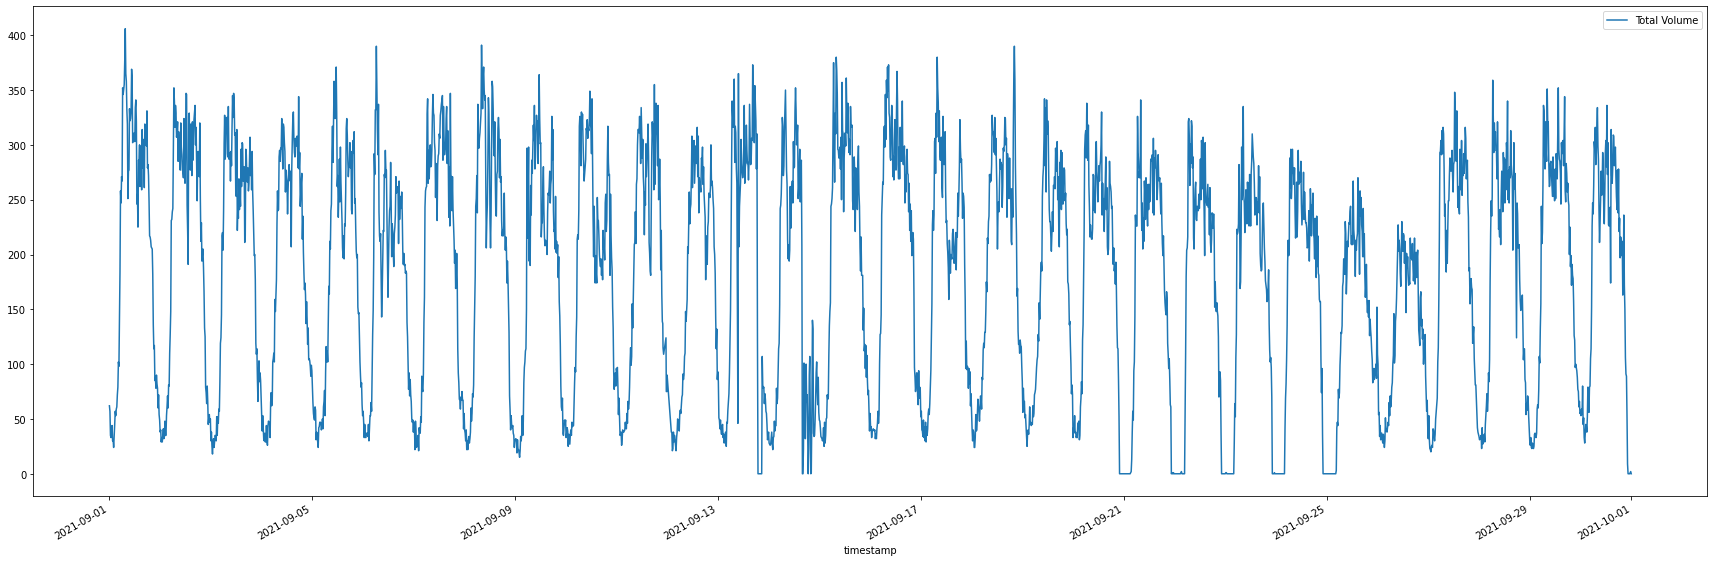

In [79]:
filterd_report = clean_report.loc[clean_report['timestamp'].dt.to_period('M')  == '2021-09']
filterd_report.plot('timestamp','Total Volume', figsize = (30,10))

<AxesSubplot:xlabel='timestamp'>

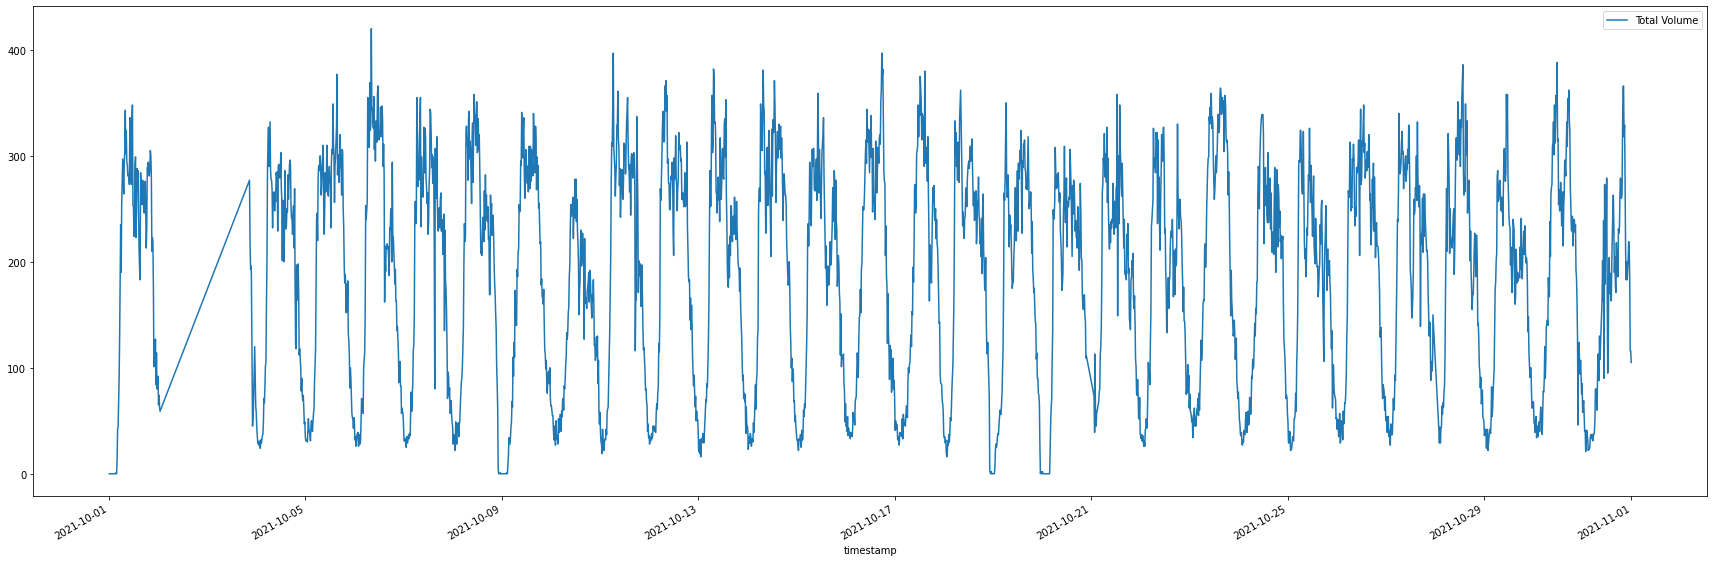

In [80]:
filterd_report = clean_report.loc[clean_report['timestamp'].dt.to_period('M')  == '2021-10']
filterd_report.plot('timestamp','Total Volume', figsize = (30,10))

### Export the dataframe

In [81]:
clean_report.to_feather('site_175_report.feather')

### Import the dataframe

In [18]:
clean_report = pd.read_feather('site_175_report.feather')

clean_report['hour'] = clean_report.timestamp.dt.hour.astype(str)
clean_report['DOW'] =  clean_report.timestamp.dt.day_of_week.astype(str)
clean_report['month'] = clean_report.timestamp.dt.month.astype(str)

In [19]:
clean_report.dtypes

Site Name                     object
Report Date                   object
Time Period Ending            object
Time Interval                 object
0 - 520 cm                    object
521 - 660 cm                  object
661 - 1160 cm                 object
1160+ cm                      object
0 - 10 mph                    object
11 - 15 mph                   object
16 - 20 mph                   object
21 - 25 mph                   object
26 - 30 mph                   object
31 - 35 mph                   object
36 - 40 mph                   object
41 - 45 mph                   object
46 - 50 mph                   object
51 - 55 mph                   object
56 - 60 mph                   object
61 - 70 mph                   object
71 - 80 mph                   object
80+ mph                       object
Avg mph                       object
Total Volume                   int32
timestamp             datetime64[ns]
hour                          object
DOW                           object
m

### Analysis of the date disributions

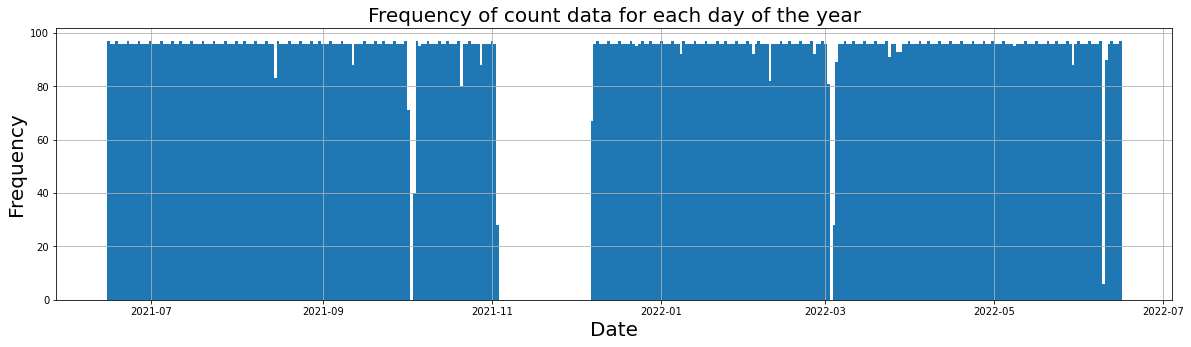

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
clean_report.timestamp.hist(ax=ax, bins=365)
ax.set_title('Frequency of count data for each day of the year', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

plt.show()

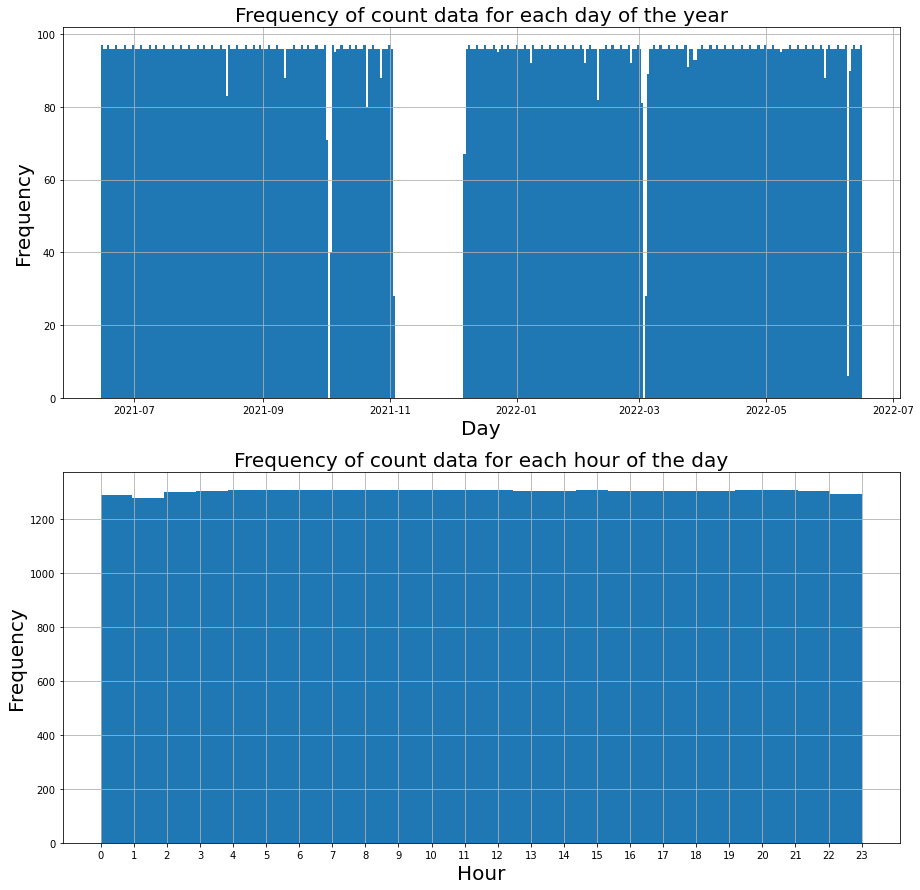

In [68]:
n_row = 2
n_col = 1

fig, ax = plt.subplots(n_row, n_col, figsize=(15,15))
clean_report.timestamp.hist(ax=ax[0], bins=365)
ax[0].set_title('Frequency of count data for each day of the year', fontsize=20)
ax[0].set_xlabel('Day', fontsize=20)
ax[0].set_ylabel('Frequency', fontsize=20)

clean_report.hour.hist(ax=ax[1], bins=24)
ax[1].set_title('Frequency of count data for each hour of the day', fontsize=20)
ax[1].set_xlabel('Hour', fontsize=20)
ax[1].set_ylabel('Frequency', fontsize=20)

plt.show()